# Anomaly Detection for Beijing Housing Price

<p>For anomaly detection, there are three main anomalies: Point Anomalies, Contextual Anomalies, Collective Anomalies.</p>

<p>For this Beijing Housing Price dataset, I will utilize some anomaly detection approaches to find the outliers of the dataset. The main algorithms I utilize for anomaly detection are Interquartile Range (IQR), Isolation Forest, One Class SVM, Local Outlier Factor, Robust Covariance and K-Nearest Neighbors (KNN). Finally, I will combine these models together to calculate the score for each data and select the anomalies which satisfy the threshold of the score, which is the safest way to do unsupervised anomaly detection.</p>

<p>Since this is a problem of unsupervised anomaly detection, I will judge the performance of each method by visualizing the anomalies among the entire dataset. Personally, I think this is an efficient way to make the judgement of the results.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from pyod.models.knn import KNN

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
df = pd.read_csv('../data/Beijing_housing_price.csv')
df.head(10)

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,116.475489,40.019520,8/9/16,1464,106,415.0,31680,131.00,2,1,1,1,1,2005,3,6,0.217,1,0,1,7,56021
1,116.453917,39.881534,7/28/16,903,126,575.0,43436,132.38,2,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539
2,116.561978,39.877145,12/11/16,1271,48,1030.0,52021,198.00,3,2,1,3,4,2005,3,6,0.500,1,0,0,7,48160
3,116.438010,40.076114,9/30/16,965,138,297.5,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588
5,116.466280,39.991363,7/22/16,861,57,275.6,52000,53.00,1,0,1,1,4,2005,3,6,0.333,1,1,0,7,67738
6,116.482586,39.891991,7/14/16,851,167,275.0,37672,73.00,2,1,1,1,4,1997,4,2,0.500,0,0,0,7,50112
7,116.453917,39.881534,9/7/16,904,138,800.0,49521,161.55,3,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539
8,116.555729,40.162058,9/4/16,873,218,134.0,27917,48.00,1,0,1,1,3,2009,1,2,0.333,0,0,0,13,44235
9,116.453086,39.898397,9/5/16,865,134,380.0,55883,68.00,1,0,0,0,1,2009,4,6,0.308,1,1,1,1,78590


# Some properties of the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152266 entries, 0 to 152265
Data columns (total 22 columns):
Lng                    152266 non-null float64
Lat                    152266 non-null float64
tradeTime              152266 non-null object
DOM                    152266 non-null int64
followers              152266 non-null int64
totalPrice             152266 non-null float64
price                  152266 non-null int64
square                 152266 non-null float64
livingRoom             152266 non-null int64
drawingRoom            152266 non-null int64
kitchen                152266 non-null int64
bathRoom               152266 non-null int64
buildingType           152266 non-null int64
constructionTime       152266 non-null int64
renovationCondition    152266 non-null int64
buildingStructure      152266 non-null int64
ladderRatio            152266 non-null float64
elevator               152266 non-null int64
fiveYearsProperty      152266 non-null int64
subway                 

In [4]:
df.describe()

,Lng,Lat,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
count,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000,1.522660e+05,152266.000000,152266.000000,152266.000000,152266.000000,152266.000000
mean,116.414684,39.948250,29.432789,26.909803,410.905238,51769.837705,82.484276,2.010876,1.144753,0.991640,1.181492,3.037428,1999.395610,3.019610,4.441950,6.611798e+01,0.575309,0.611286,0.597185,6.691848,63319.669979
std,0.113486,0.094753,50.372756,44.398808,253.622889,24163.276811,36.479193,0.771432,0.508481,0.116663,0.426578,1.260005,8.990568,1.142767,1.905362,2.565113e+04,0.494298,0.487460,0.490466,2.842577,22215.723477
min,116.072514,39.627030,1.000000,0.000000,0.100000,1.000000,7.370000,0.000000,0.000000,0.000000,0.000000,1.000000,1950.000000,1.000000,1.000000,1.400000e-02,0.000000,0.000000,0.000000,1.000000,10847.000000
25%,116.343245,39.891739,1.000000,2.000000,248.000000,34166.250000,57.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1994.000000,3.000000,2.000000,2.500000e-01,0.000000,0.000000,0.000000,6.000000,46035.000000
50%,116.416156,39.933924,7.000000,12.000000,355.000000,47094.000000,73.460000,2.000000,1.000000,1.000000,1.000000,4.000000,2002.000000,3.000000,6.000000,3.330000e-01,1.000000,1.000000,1.000000,7.000000,58947.500000
75%,116.476546,40.002156,38.000000,33.000000,502.225000,64884.750000,97.520000,2.000000,1.000000,1.000000,1.000000,4.000000,2006.000000,4.000000,6.000000,5.000000e-01,1.000000,1.000000,1.000000,8.000000,75604.000000
max,116.711337,40.252758,1677.000000,1143.000000,4900.000000,150000.000000,640.000000,7.000000,5.000000,3.000000,6.000000,4.000000,2016.000000,4.000000,6.000000,1.000940e+07,1.000000,1.000000,1.000000,13.000000,183109.000000


In [5]:
df.isna().any()

Lng                    False
Lat                    False
tradeTime              False
DOM                    False
followers              False
totalPrice             False
price                  False
square                 False
livingRoom             False
drawingRoom            False
kitchen                False
bathRoom               False
buildingType           False
constructionTime       False
renovationCondition    False
buildingStructure      False
ladderRatio            False
elevator               False
fiveYearsProperty      False
subway                 False
district               False
communityAverage       False
dtype: bool

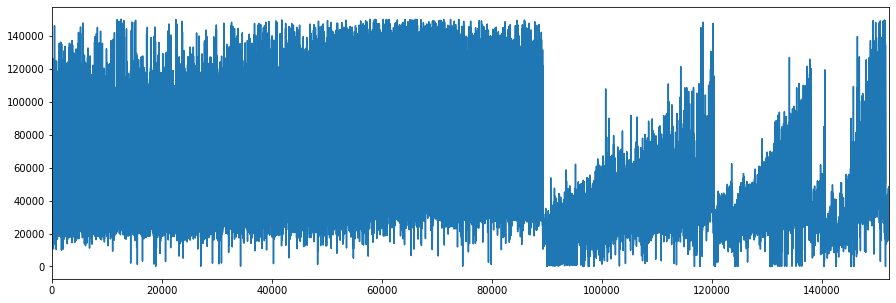

In [6]:
df['price'].plot(figsize=[15, 5])

# Feature Engineering

<p>The housing prices may depend on the years and the months when the houses were sold, thus two additional features are generated from the date.</p>

In [7]:
df['Years'] = df['tradeTime'].astype('str').apply(lambda x: int(x.split('/')[2]))
df['Months'] = df['tradeTime'].astype('str').apply(lambda x: int(x.split('/')[0]))
df.head(10)

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months
0,116.475489,40.019520,8/9/16,1464,106,415.0,31680,131.00,2,1,1,1,1,2005,3,6,0.217,1,0,1,7,56021,16,8
1,116.453917,39.881534,7/28/16,903,126,575.0,43436,132.38,2,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,7
2,116.561978,39.877145,12/11/16,1271,48,1030.0,52021,198.00,3,2,1,3,4,2005,3,6,0.500,1,0,0,7,48160,16,12
3,116.438010,40.076114,9/30/16,965,138,297.5,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238,16,9
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588,16,8
5,116.466280,39.991363,7/22/16,861,57,275.6,52000,53.00,1,0,1,1,4,2005,3,6,0.333,1,1,0,7,67738,16,7
6,116.482586,39.891991,7/14/16,851,167,275.0,37672,73.00,2,1,1,1,4,1997,4,2,0.500,0,0,0,7,50112,16,7
7,116.453917,39.881534,9/7/16,904,138,800.0,49521,161.55,3,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,9
8,116.555729,40.162058,9/4/16,873,218,134.0,27917,48.00,1,0,1,1,3,2009,1,2,0.333,0,0,0,13,44235,16,9
9,116.453086,39.898397,9/5/16,865,134,380.0,55883,68.00,1,0,0,0,1,2009,4,6,0.308,1,1,1,1,78590,16,9


## Histogram of the dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x102a89990>]],
      dtype=object)

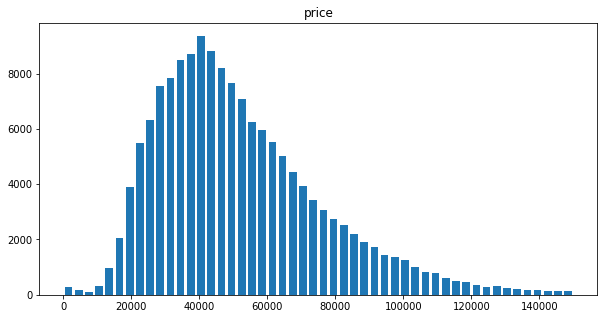

In [8]:
df.hist(column='price', bins=50, grid=False, figsize=[10,5], rwidth=0.75)

## Histogram by years

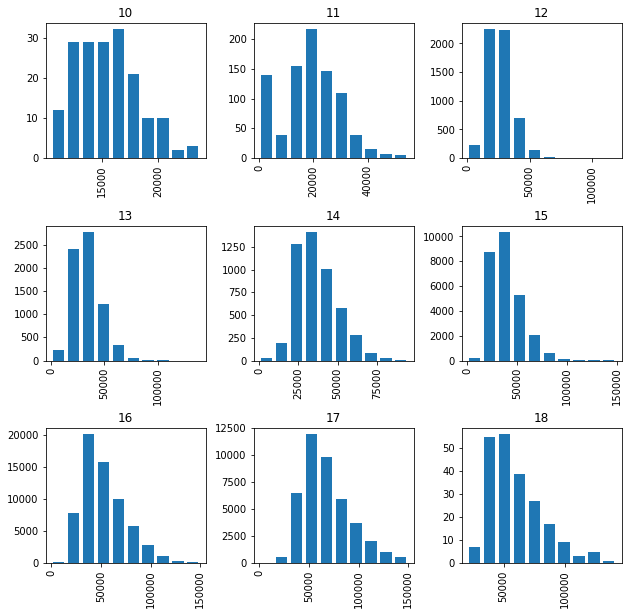

In [9]:
df.hist(column='price', by='Years', bins=10, grid=False, figsize=[10,10], rwidth=0.75)
plt.show()

## Histogram by months

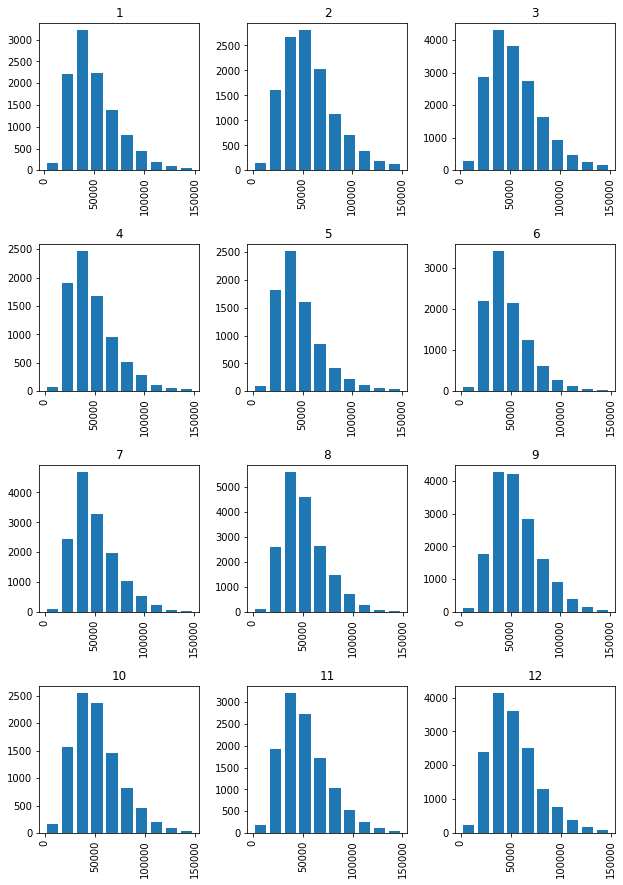

In [10]:
df.hist(column='price', by='Months', bins=10, grid=False, figsize=[10,15], rwidth=0.75)
plt.show()

## Select features

In [11]:
data = df[['followers', 
           'price', 
           'square', 
           'kitchen', 
           'buildingType', 
           'renovationCondition', 
           'buildingStructure', 
           'ladderRatio', 
           'elevator', 
           'subway', 
           'district',
           'Years', 
           'Months']]
data.head(10)

,followers,price,square,kitchen,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,subway,district,Years,Months
0,106,31680,131.00,1,1,3,6,0.217,1,1,7,16,8
1,126,43436,132.38,1,1,4,6,0.667,1,0,7,16,7
2,48,52021,198.00,1,4,3,6,0.500,1,0,7,16,12
3,138,22202,134.00,1,1,1,6,0.273,1,0,6,16,9
4,286,48396,81.00,1,4,2,2,0.333,0,1,1,16,8
5,57,52000,53.00,1,4,3,6,0.333,1,0,7,16,7
6,167,37672,73.00,1,4,4,2,0.500,0,0,7,16,7
7,138,49521,161.55,1,1,4,6,0.667,1,0,7,16,9
8,218,27917,48.00,1,3,1,2,0.333,0,0,13,16,9
9,134,55883,68.00,0,1,4,6,0.308,1,1,1,16,9


In [12]:
data.isna().any()

followers              False
price                  False
square                 False
kitchen                False
buildingType           False
renovationCondition    False
buildingStructure      False
ladderRatio            False
elevator               False
subway                 False
district               False
Years                  False
Months                 False
dtype: bool

## PCA

<p>Utilizing PCA to reduce the number of features. 3 components are good enough to do the anomaly detection.</p>

In [13]:
pca = PCA(n_components=3)
pca.fit(data)
data = pca.transform(data)

# Anomaly Detection

## Interquartile Range (IQR)

### Lower bound and upper bound

In [14]:
q1 = df.price.quantile(0.25)
q3 = df.price.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr)

print('The lower bound of the IQR is {}'.format(lower_bound))
print('The upper bound of the IQR is {}'.format(upper_bound))

The lower bound of the IQR is -11911.5
The upper bound of the IQR is 110962.5


### The outliers beyond the bounds

In [15]:
df_outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print('The number of outliers is {}'.format(len(df_outliers.index)))
df_outliers.head(10)

The number of outliers is 3727


,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months
162,116.388606,39.965854,10/25/16,474,239,560.0,119684,46.79,1,1,1,1,3,2009,4,6,0.500,1,1,0,10,127398,16,10
225,116.387037,39.959170,1/7/17,505,233,644.0,126250,51.01,1,1,1,1,4,2003,3,6,0.333,0,0,1,10,119449,17,1
465,116.373085,39.921965,7/16/16,245,44,828.0,146161,56.65,1,1,1,1,1,1999,3,6,0.222,1,0,1,10,165490,16,7
486,116.330345,39.984336,6/23/16,219,35,495.0,125317,39.50,1,1,1,1,3,1989,3,6,0.125,1,1,1,8,114107,16,6
795,116.372543,39.927054,9/22/16,258,64,1126.0,119116,94.53,2,2,1,1,3,2008,4,6,0.250,1,0,1,10,133828,16,9
828,116.382621,39.957951,7/24/16,195,63,630.0,124753,50.50,1,1,0,1,4,2009,4,6,0.333,1,1,1,10,153344,16,7
946,116.383881,39.909637,11/10/16,292,57,1550.0,118249,131.08,3,1,1,2,1,2009,4,6,0.333,1,0,1,10,104368,16,11
1256,116.340073,39.899642,8/16/16,173,44,1050.0,112904,93.00,4,2,1,2,3,2011,4,6,0.400,1,0,1,10,101676,16,8
1294,116.437847,39.933684,8/30/16,186,88,600.0,125209,47.92,1,1,1,1,4,2003,4,6,0.250,1,0,1,1,117682,16,8
1316,116.383994,39.890405,8/4/16,160,48,1750.0,122455,142.91,3,2,1,2,3,2014,2,6,0.333,0,0,1,10,137745,16,8


### Add the results to Data Frame

In [16]:
IQR = np.zeros(df.index.size).astype(int)
IQR[df_outliers.index] = int(-1)
df['IQR'] = IQR
df[df['IQR'] == -1].head(10)

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR
162,116.388606,39.965854,10/25/16,474,239,560.0,119684,46.79,1,1,1,1,3,2009,4,6,0.500,1,1,0,10,127398,16,10,-1
225,116.387037,39.959170,1/7/17,505,233,644.0,126250,51.01,1,1,1,1,4,2003,3,6,0.333,0,0,1,10,119449,17,1,-1
465,116.373085,39.921965,7/16/16,245,44,828.0,146161,56.65,1,1,1,1,1,1999,3,6,0.222,1,0,1,10,165490,16,7,-1
486,116.330345,39.984336,6/23/16,219,35,495.0,125317,39.50,1,1,1,1,3,1989,3,6,0.125,1,1,1,8,114107,16,6,-1
795,116.372543,39.927054,9/22/16,258,64,1126.0,119116,94.53,2,2,1,1,3,2008,4,6,0.250,1,0,1,10,133828,16,9,-1
828,116.382621,39.957951,7/24/16,195,63,630.0,124753,50.50,1,1,0,1,4,2009,4,6,0.333,1,1,1,10,153344,16,7,-1
946,116.383881,39.909637,11/10/16,292,57,1550.0,118249,131.08,3,1,1,2,1,2009,4,6,0.333,1,0,1,10,104368,16,11,-1
1256,116.340073,39.899642,8/16/16,173,44,1050.0,112904,93.00,4,2,1,2,3,2011,4,6,0.400,1,0,1,10,101676,16,8,-1
1294,116.437847,39.933684,8/30/16,186,88,600.0,125209,47.92,1,1,1,1,4,2003,4,6,0.250,1,0,1,1,117682,16,8,-1
1316,116.383994,39.890405,8/4/16,160,48,1750.0,122455,142.91,3,2,1,2,3,2014,2,6,0.333,0,0,1,10,137745,16,8,-1


### Visualize the Anomaly Detection with IQR

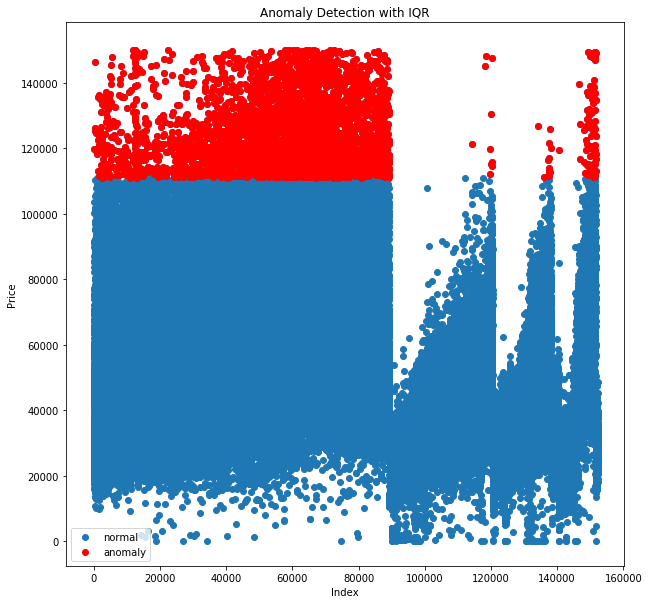

In [17]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['IQR'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with IQR')
plt.legend()
plt.show()

### Distribution of the anomalies detected by IQR

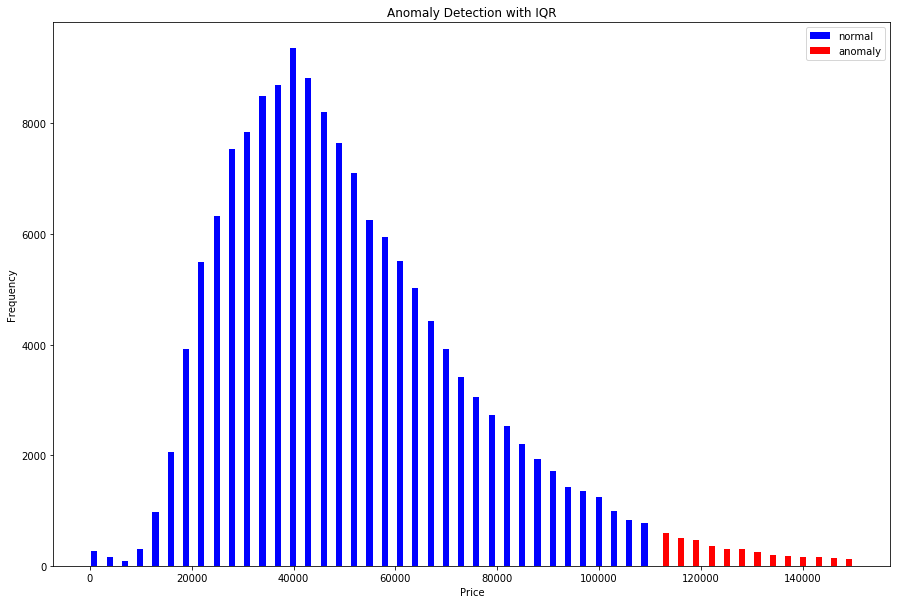

In [18]:
normal = df.loc[df['IQR'] == 0, 'price']
anomaly = df.loc[df['IQR'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Anomaly Detection with IQR')
plt.legend()
plt.show()

## Isolation Forest

In [19]:
isolation_forest = IsolationForest(n_estimators=1000, max_samples=5000, contamination=0.025)
isolation_forest.fit(data)
outliers_prediction = isolation_forest.predict(data)
outliers_prediction[outliers_prediction == 1] = 0
df['IsolationForest'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['IsolationForest'] == -1].head(10)

The number of outliers is 3807


,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR,IsolationForest
3,116.438010,40.076114,9/30/16,965,138,297.5,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238,16,9,0,-1
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588,16,8,0,-1
8,116.555729,40.162058,9/4/16,873,218,134.0,27917,48.00,1,0,1,1,3,2009,1,2,0.333,0,0,0,13,44235,16,9,0,-1
19,116.448302,39.960966,7/28/16,697,276,176.0,29000,60.69,1,1,1,1,1,2008,4,6,0.364,1,1,0,7,34966,16,7,0,-1
59,116.384103,39.972885,8/15/16,498,213,642.0,89665,71.60,2,1,1,1,3,1993,1,2,0.222,1,0,0,10,129541,16,8,0,-1
60,116.497474,39.810115,7/7/16,459,266,165.0,29741,55.48,1,1,1,1,1,2009,4,6,0.250,1,0,1,3,54282,16,7,0,-1
83,116.606151,40.051276,1/22/17,629,172,300.0,29127,103.00,3,1,1,1,4,1998,4,2,0.500,0,1,0,7,38468,17,1,0,-1
88,116.166080,39.771077,9/30/16,511,264,210.5,32377,65.00,1,1,1,1,1,2011,4,6,0.167,1,0,0,5,34373,16,9,0,-1
98,116.508181,39.807662,8/29/16,470,154,145.0,27272,53.17,1,1,0,0,1,2008,3,6,0.200,1,0,1,3,28609,16,8,0,-1
103,116.164506,39.731851,8/23/16,457,129,188.0,21600,87.04,2,1,1,1,4,2004,3,2,0.500,0,1,1,5,32095,16,8,0,-1


### Visualize the Anomaly Detection with Isolation Forest

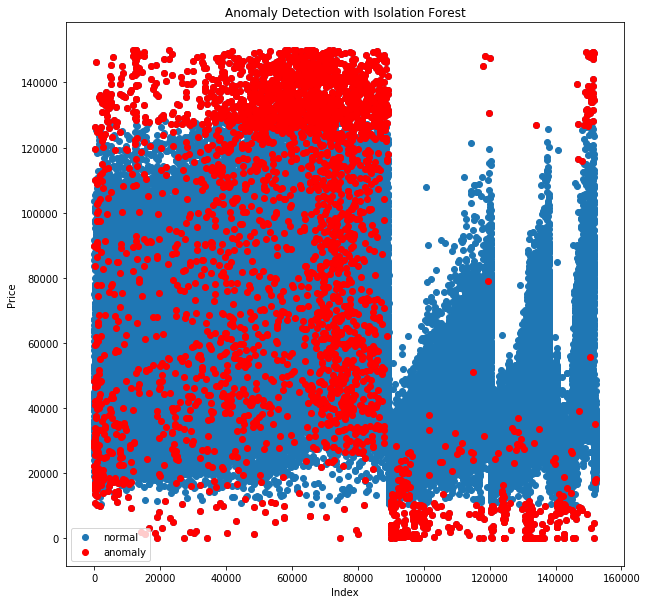

In [20]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['IsolationForest'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with Isolation Forest')
plt.legend()
plt.show()

### Distribution of the anomalies detected by Isolation Forest

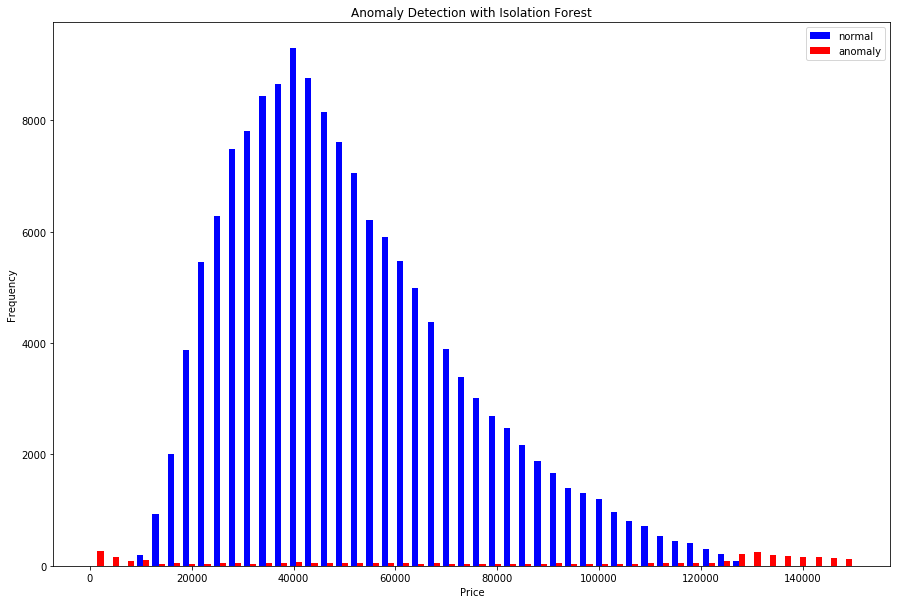

In [21]:
normal = df.loc[df['IsolationForest'] == 0, 'price']
anomaly = df.loc[df['IsolationForest'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Anomaly Detection with Isolation Forest')
plt.legend()
plt.show()

## One Class SVM

In [22]:
one_class_svm = OneClassSVM(gamma=0.00000000005, nu=0.025)
one_class_svm.fit(data)
outliers_prediction = one_class_svm.predict(data)
outliers_prediction[outliers_prediction == 1] = 0
df['OneClassSVM'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['OneClassSVM'] == -1].head(10)

The number of outliers is 3807


,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR,IsolationForest,OneClassSVM
225,116.387037,39.959170,1/7/17,505,233,644.0,126250,51.01,1,1,1,1,4,2003,3,6,0.333,0,0,1,10,119449,17,1,-1,-1,-1
262,116.128533,39.723864,7/8/16,308,10,299.0,10641,281.00,3,2,1,2,4,2011,3,6,0.500,1,0,1,5,30846,16,7,0,-1,-1
316,116.670768,40.209956,8/27/16,337,51,150.0,13441,111.60,3,2,1,2,4,2008,4,6,0.333,1,0,0,13,47194,16,8,0,-1,-1
317,116.670768,40.209956,8/27/16,337,36,170.0,15233,111.60,3,2,1,2,4,2008,4,6,0.333,1,0,0,13,47194,16,8,0,-1,-1
364,116.121949,40.215899,9/7/16,330,48,148.0,14833,99.78,3,1,1,1,4,1998,3,2,0.333,0,1,0,6,28158,16,9,0,-1,-1
423,116.319699,39.627030,8/21/16,296,28,242.0,13396,180.66,3,2,1,2,1,2005,4,6,0.250,0,1,0,4,30673,16,8,0,-1,-1
465,116.373085,39.921965,7/16/16,245,44,828.0,146161,56.65,1,1,1,1,1,1999,3,6,0.222,1,0,1,10,165490,16,7,-1,-1,-1
486,116.330345,39.984336,6/23/16,219,35,495.0,125317,39.50,1,1,1,1,3,1989,3,6,0.125,1,1,1,8,114107,16,6,-1,0,-1
772,116.673912,40.209832,7/11/16,186,27,200.0,12821,156.00,3,3,1,2,4,2008,1,6,0.250,1,0,0,13,35734,16,7,0,-1,-1
773,116.673912,40.209832,7/11/16,186,39,160.0,10257,156.00,3,3,1,2,4,2008,1,6,0.250,1,0,0,13,35734,16,7,0,-1,-1


### Visualize the Anomaly Detection with One Class SVM

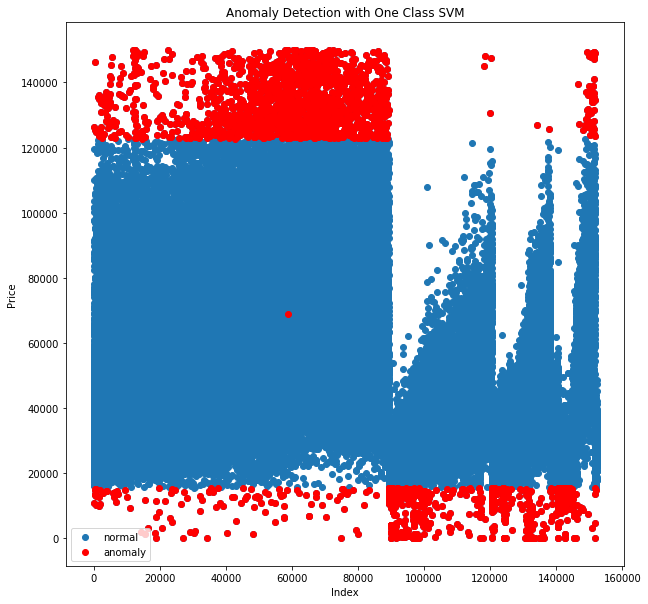

In [23]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['OneClassSVM'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with One Class SVM')
plt.legend()
plt.show()

### Distribution of the anomalies detected by One Class SVM

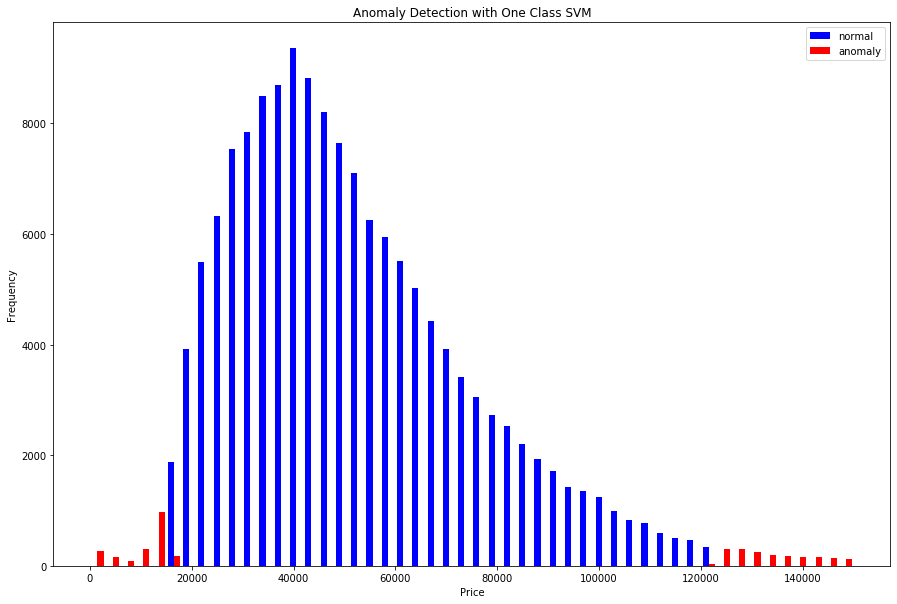

In [24]:
normal = df.loc[df['OneClassSVM'] == 0, 'price']
anomaly = df.loc[df['OneClassSVM'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Anomaly Detection with One Class SVM')
plt.legend()
plt.show()

## Local Outlier Factor

In [25]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=4000, contamination=0.025)
outliers_prediction = local_outlier_factor.fit_predict(data)
outliers_prediction[outliers_prediction == 1] = 0
df['LocalOutlierFactor'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['LocalOutlierFactor'] == -1].head(10)

The number of outliers is 3807


,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor
225,116.387037,39.959170,1/7/17,505,233,644.0,126250,51.01,1,1,1,1,4,2003,3,6,0.333,0,0,1,10,119449,17,1,-1,-1,-1,-1
262,116.128533,39.723864,7/8/16,308,10,299.0,10641,281.00,3,2,1,2,4,2011,3,6,0.500,1,0,1,5,30846,16,7,0,-1,-1,-1
316,116.670768,40.209956,8/27/16,337,51,150.0,13441,111.60,3,2,1,2,4,2008,4,6,0.333,1,0,0,13,47194,16,8,0,-1,-1,-1
317,116.670768,40.209956,8/27/16,337,36,170.0,15233,111.60,3,2,1,2,4,2008,4,6,0.333,1,0,0,13,47194,16,8,0,-1,-1,-1
364,116.121949,40.215899,9/7/16,330,48,148.0,14833,99.78,3,1,1,1,4,1998,3,2,0.333,0,1,0,6,28158,16,9,0,-1,-1,-1
423,116.319699,39.627030,8/21/16,296,28,242.0,13396,180.66,3,2,1,2,1,2005,4,6,0.250,0,1,0,4,30673,16,8,0,-1,-1,-1
465,116.373085,39.921965,7/16/16,245,44,828.0,146161,56.65,1,1,1,1,1,1999,3,6,0.222,1,0,1,10,165490,16,7,-1,-1,-1,-1
486,116.330345,39.984336,6/23/16,219,35,495.0,125317,39.50,1,1,1,1,3,1989,3,6,0.125,1,1,1,8,114107,16,6,-1,0,-1,-1
772,116.673912,40.209832,7/11/16,186,27,200.0,12821,156.00,3,3,1,2,4,2008,1,6,0.250,1,0,0,13,35734,16,7,0,-1,-1,-1
773,116.673912,40.209832,7/11/16,186,39,160.0,10257,156.00,3,3,1,2,4,2008,1,6,0.250,1,0,0,13,35734,16,7,0,-1,-1,-1


### Visualize the Anomaly Detection with Local Outlier Factor

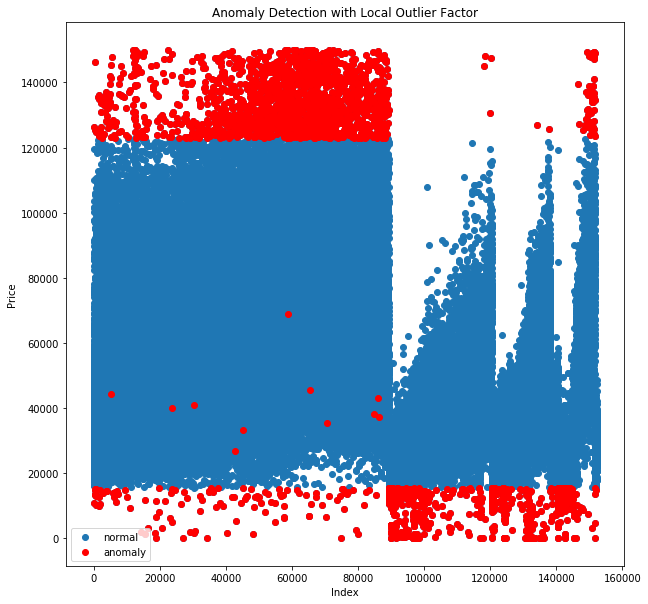

In [26]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['LocalOutlierFactor'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with Local Outlier Factor')
plt.legend()
plt.show()

### Distribution of the anomalies detected by Local Outlier Factor

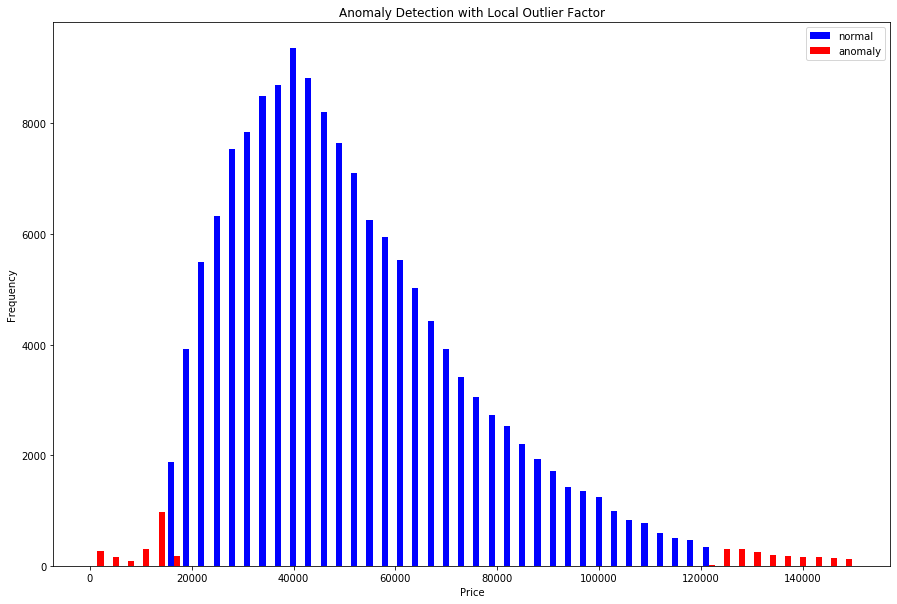

In [27]:
normal = df.loc[df['LocalOutlierFactor'] == 0, 'price']
anomaly = df.loc[df['LocalOutlierFactor'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Anomaly Detection with Local Outlier Factor')
plt.legend()
plt.show()

## Robust Covariance

In [28]:
elliptic_envelope = EllipticEnvelope(assume_centered=True, support_fraction=0.00001, contamination=0.025)
elliptic_envelope.fit(data)
outliers_prediction = elliptic_envelope.predict(data)
outliers_prediction[outliers_prediction == 1] = 0
df['RobustCovariance'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['RobustCovariance'] == -1].head(10)

The number of outliers is 3807


,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588,16,8,0,-1,0,0,-1
8,116.555729,40.162058,9/4/16,873,218,134.0,27917,48.00,1,0,1,1,3,2009,1,2,0.333,0,0,0,13,44235,16,9,0,-1,0,0,-1
19,116.448302,39.960966,7/28/16,697,276,176.0,29000,60.69,1,1,1,1,1,2008,4,6,0.364,1,1,0,7,34966,16,7,0,-1,0,0,-1
31,116.485296,39.991732,9/27/16,628,268,590.0,51687,114.15,2,2,1,1,1,2001,1,6,0.375,1,0,1,7,53538,16,9,0,0,0,0,-1
59,116.384103,39.972885,8/15/16,498,213,642.0,89665,71.60,2,1,1,1,3,1993,1,2,0.222,1,0,0,10,129541,16,8,0,-1,0,0,-1
60,116.497474,39.810115,7/7/16,459,266,165.0,29741,55.48,1,1,1,1,1,2009,4,6,0.250,1,0,1,3,54282,16,7,0,-1,0,0,-1
88,116.166080,39.771077,9/30/16,511,264,210.5,32377,65.00,1,1,1,1,1,2011,4,6,0.167,1,0,0,5,34373,16,9,0,-1,0,0,-1
105,116.511545,39.904464,12/30/16,581,243,210.0,42000,50.00,1,1,1,1,1,2010,4,6,0.105,1,1,1,7,59025,16,12,0,0,0,0,-1
106,116.342088,39.749733,6/19/16,385,263,220.0,30051,73.21,2,1,1,1,4,1992,4,2,0.500,0,1,1,4,41149,16,6,0,-1,0,0,-1
153,116.418443,39.866651,8/16/16,409,310,246.8,46567,53.00,2,1,1,1,4,1975,3,2,0.333,0,0,0,1,66495,16,8,0,-1,0,0,-1


### Visualize the Anomaly Detection with Robust Covariance

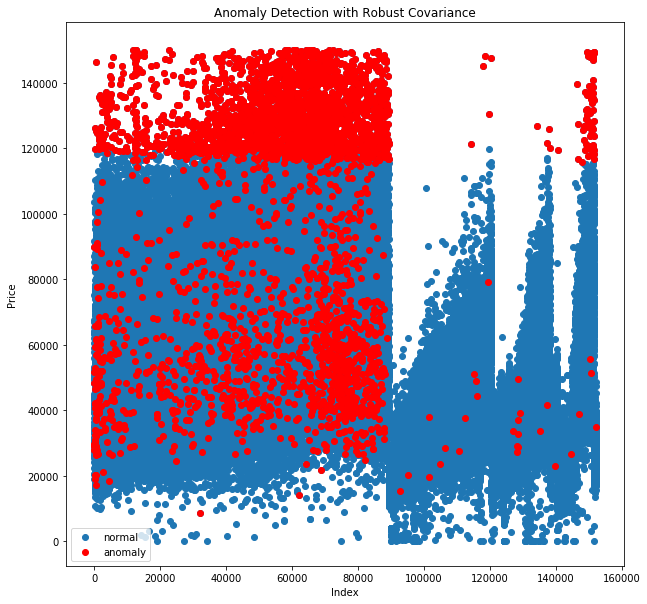

In [29]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['RobustCovariance'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with Robust Covariance')
plt.legend()
plt.show()

### Distribution of the anomalies detected by Robust Covariance

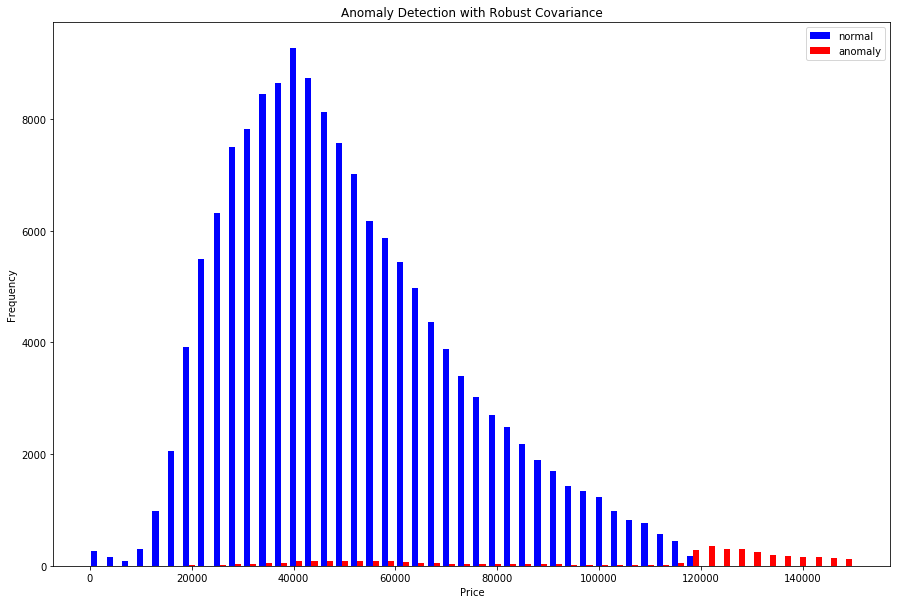

In [30]:
normal = df.loc[df['RobustCovariance'] == 0, 'price']
anomaly = df.loc[df['RobustCovariance'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Anomaly Detection with Robust Covariance')
plt.legend()
plt.show()

## KNN

In [31]:
knn = KNN(contamination=0.025, n_neighbors=1000)
knn.fit(data)
outliers_prediction = knn.labels_
outliers_prediction[outliers_prediction == 1] = -1
df['KNN'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['KNN'] == -1].head(10)

The number of outliers is 3807


,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance,KNN
162,116.388606,39.965854,10/25/16,474,239,560.0,119684,46.79,1,1,1,1,3,2009,4,6,0.500,1,1,0,10,127398,16,10,-1,-1,0,0,-1,-1
225,116.387037,39.959170,1/7/17,505,233,644.0,126250,51.01,1,1,1,1,4,2003,3,6,0.333,0,0,1,10,119449,17,1,-1,-1,-1,-1,-1,-1
262,116.128533,39.723864,7/8/16,308,10,299.0,10641,281.00,3,2,1,2,4,2011,3,6,0.500,1,0,1,5,30846,16,7,0,-1,-1,-1,0,-1
465,116.373085,39.921965,7/16/16,245,44,828.0,146161,56.65,1,1,1,1,1,1999,3,6,0.222,1,0,1,10,165490,16,7,-1,-1,-1,-1,-1,-1
486,116.330345,39.984336,6/23/16,219,35,495.0,125317,39.50,1,1,1,1,3,1989,3,6,0.125,1,1,1,8,114107,16,6,-1,0,-1,-1,-1,-1
773,116.673912,40.209832,7/11/16,186,39,160.0,10257,156.00,3,3,1,2,4,2008,1,6,0.250,1,0,0,13,35734,16,7,0,-1,-1,-1,0,-1
795,116.372543,39.927054,9/22/16,258,64,1126.0,119116,94.53,2,2,1,1,3,2008,4,6,0.250,1,0,1,10,133828,16,9,-1,0,0,0,0,-1
828,116.382621,39.957951,7/24/16,195,63,630.0,124753,50.50,1,1,0,1,4,2009,4,6,0.333,1,1,1,10,153344,16,7,-1,-1,-1,-1,-1,-1
946,116.383881,39.909637,11/10/16,292,57,1550.0,118249,131.08,3,1,1,2,1,2009,4,6,0.333,1,0,1,10,104368,16,11,-1,0,0,0,0,-1
1294,116.437847,39.933684,8/30/16,186,88,600.0,125209,47.92,1,1,1,1,4,2003,4,6,0.250,1,0,1,1,117682,16,8,-1,-1,-1,-1,-1,-1


### Visualize the Anomaly Detection with KNN

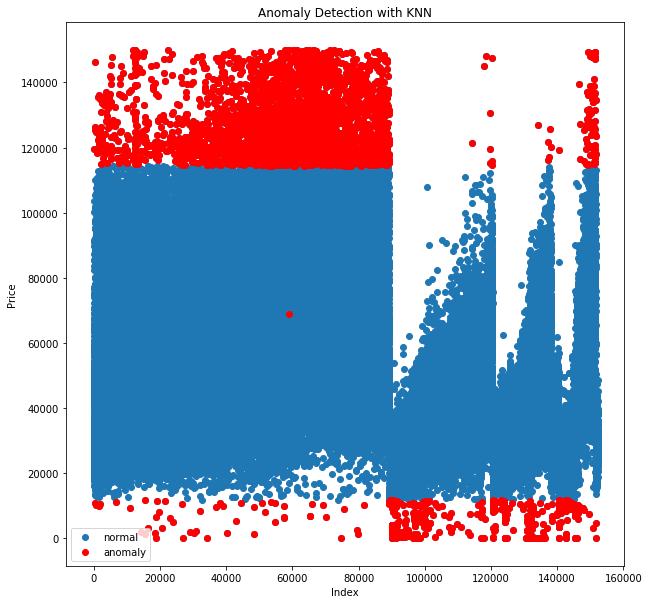

In [32]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['KNN'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with KNN')
plt.legend()
plt.show()

### Distribution of the anomalies detected by KNN

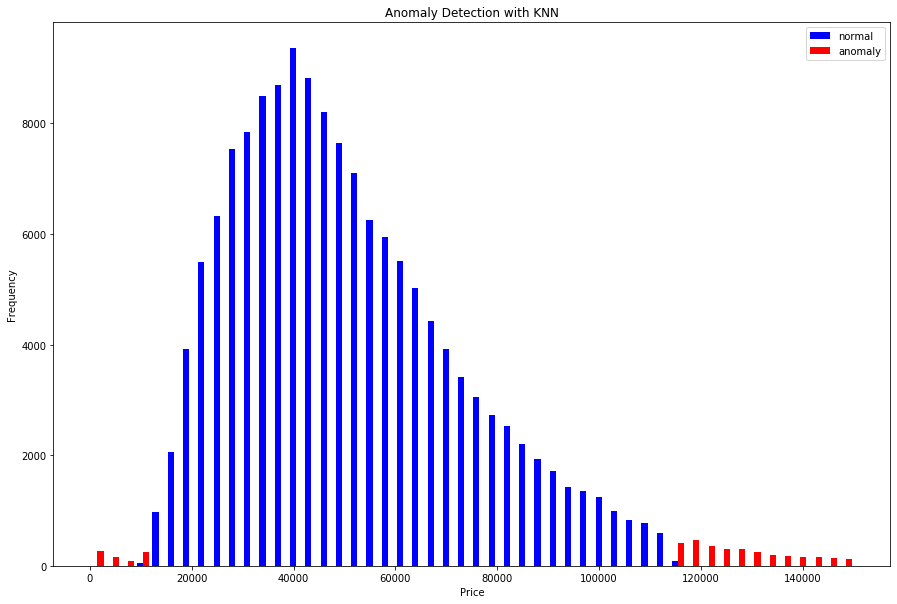

In [33]:
normal = df.loc[df['KNN'] == 0, 'price']
anomaly = df.loc[df['KNN'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Anomaly Detection with KNN')
plt.legend()
plt.show()

## Combination of all Models

<p>For each model, if the model thinks one data is anomaly point, then it will be denoted as -1 by this model. If the model thinks one data is normal point, it will be denoted as 0 by this model.</p>
<p>After the anomaly detection for each model, I sum up the score for each data. Totally we have 6 models for anomaly detection. If a data has score less than or equal to -4 which means at least 4 models think it as anomaly, it will be treated as anomaly point. Otherwise, the point is normal.</p>

In [34]:
df.head(10)

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance,KNN
0,116.475489,40.019520,8/9/16,1464,106,415.0,31680,131.00,2,1,1,1,1,2005,3,6,0.217,1,0,1,7,56021,16,8,0,0,0,0,0,0
1,116.453917,39.881534,7/28/16,903,126,575.0,43436,132.38,2,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,7,0,0,0,0,0,0
2,116.561978,39.877145,12/11/16,1271,48,1030.0,52021,198.00,3,2,1,3,4,2005,3,6,0.500,1,0,0,7,48160,16,12,0,0,0,0,0,0
3,116.438010,40.076114,9/30/16,965,138,297.5,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238,16,9,0,-1,0,0,0,0
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588,16,8,0,-1,0,0,-1,0
5,116.466280,39.991363,7/22/16,861,57,275.6,52000,53.00,1,0,1,1,4,2005,3,6,0.333,1,1,0,7,67738,16,7,0,0,0,0,0,0
6,116.482586,39.891991,7/14/16,851,167,275.0,37672,73.00,2,1,1,1,4,1997,4,2,0.500,0,0,0,7,50112,16,7,0,0,0,0,0,0
7,116.453917,39.881534,9/7/16,904,138,800.0,49521,161.55,3,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,9,0,0,0,0,0,0
8,116.555729,40.162058,9/4/16,873,218,134.0,27917,48.00,1,0,1,1,3,2009,1,2,0.333,0,0,0,13,44235,16,9,0,-1,0,0,-1,0
9,116.453086,39.898397,9/5/16,865,134,380.0,55883,68.00,1,0,0,0,1,2009,4,6,0.308,1,1,1,1,78590,16,9,0,0,0,0,0,0


### Calculate the anomaly score with all models

In [35]:
df['AnomalyScore'] = df.apply(lambda x: x.IQR + 
                                        x.IsolationForest + 
                                        x.OneClassSVM + 
                                        x.LocalOutlierFactor + 
                                        x.RobustCovariance + 
                                        x.KNN, 
                              axis=1)
df.head(10)

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance,KNN,AnomalyScore
0,116.475489,40.019520,8/9/16,1464,106,415.0,31680,131.00,2,1,1,1,1,2005,3,6,0.217,1,0,1,7,56021,16,8,0,0,0,0,0,0,0
1,116.453917,39.881534,7/28/16,903,126,575.0,43436,132.38,2,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,7,0,0,0,0,0,0,0
2,116.561978,39.877145,12/11/16,1271,48,1030.0,52021,198.00,3,2,1,3,4,2005,3,6,0.500,1,0,0,7,48160,16,12,0,0,0,0,0,0,0
3,116.438010,40.076114,9/30/16,965,138,297.5,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238,16,9,0,-1,0,0,0,0,-1
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588,16,8,0,-1,0,0,-1,0,-2
5,116.466280,39.991363,7/22/16,861,57,275.6,52000,53.00,1,0,1,1,4,2005,3,6,0.333,1,1,0,7,67738,16,7,0,0,0,0,0,0,0
6,116.482586,39.891991,7/14/16,851,167,275.0,37672,73.00,2,1,1,1,4,1997,4,2,0.500,0,0,0,7,50112,16,7,0,0,0,0,0,0,0
7,116.453917,39.881534,9/7/16,904,138,800.0,49521,161.55,3,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,9,0,0,0,0,0,0,0
8,116.555729,40.162058,9/4/16,873,218,134.0,27917,48.00,1,0,1,1,3,2009,1,2,0.333,0,0,0,13,44235,16,9,0,-1,0,0,-1,0,-2
9,116.453086,39.898397,9/5/16,865,134,380.0,55883,68.00,1,0,0,0,1,2009,4,6,0.308,1,1,1,1,78590,16,9,0,0,0,0,0,0,0


### Select the outliers by setting a threshold of the anomaly score

In [36]:
df_outliers = df[df['AnomalyScore'] <= -4]
df_outliers.head(10)

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance,KNN,AnomalyScore
162,116.388606,39.965854,10/25/16,474,239,560.0,119684,46.79,1,1,1,1,3,2009,4,6,0.500,1,1,0,10,127398,16,10,-1,-1,0,0,-1,-1,-4
225,116.387037,39.959170,1/7/17,505,233,644.0,126250,51.01,1,1,1,1,4,2003,3,6,0.333,0,0,1,10,119449,17,1,-1,-1,-1,-1,-1,-1,-6
262,116.128533,39.723864,7/8/16,308,10,299.0,10641,281.00,3,2,1,2,4,2011,3,6,0.500,1,0,1,5,30846,16,7,0,-1,-1,-1,0,-1,-4
465,116.373085,39.921965,7/16/16,245,44,828.0,146161,56.65,1,1,1,1,1,1999,3,6,0.222,1,0,1,10,165490,16,7,-1,-1,-1,-1,-1,-1,-6
486,116.330345,39.984336,6/23/16,219,35,495.0,125317,39.50,1,1,1,1,3,1989,3,6,0.125,1,1,1,8,114107,16,6,-1,0,-1,-1,-1,-1,-5
773,116.673912,40.209832,7/11/16,186,39,160.0,10257,156.00,3,3,1,2,4,2008,1,6,0.250,1,0,0,13,35734,16,7,0,-1,-1,-1,0,-1,-4
828,116.382621,39.957951,7/24/16,195,63,630.0,124753,50.50,1,1,0,1,4,2009,4,6,0.333,1,1,1,10,153344,16,7,-1,-1,-1,-1,-1,-1,-6
1294,116.437847,39.933684,8/30/16,186,88,600.0,125209,47.92,1,1,1,1,4,2003,4,6,0.250,1,0,1,1,117682,16,8,-1,-1,-1,-1,-1,-1,-6
1336,116.373085,39.921965,8/21/16,176,147,950.0,135521,70.10,3,1,1,1,3,1999,4,6,1.000,1,1,0,10,165490,16,8,-1,-1,-1,-1,-1,-1,-6
1536,116.435839,39.933367,7/16/16,135,25,506.0,123415,41.00,1,1,1,1,4,1993,3,2,0.250,0,0,1,1,128668,16,7,-1,0,-1,-1,-1,-1,-5


### Visualize the Anomaly Detection with all models

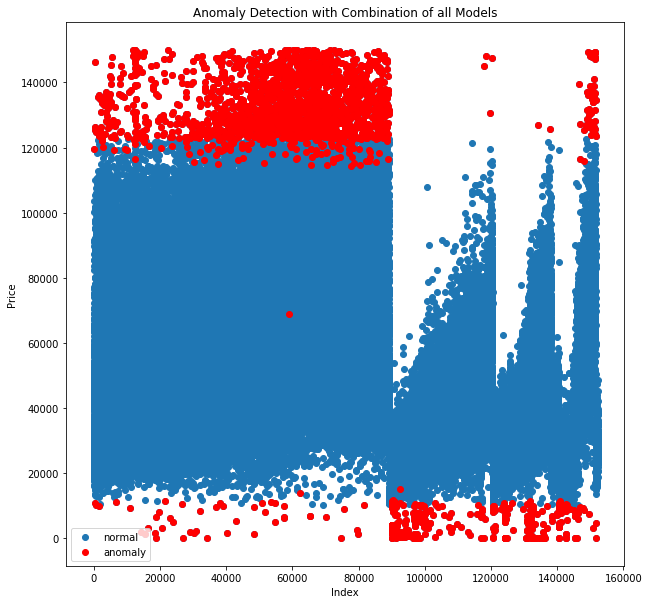

In [37]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df_outliers[['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index,a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with Combination of all Models')
plt.legend()
plt.show()

### Distribution of the anomalies detected by all models

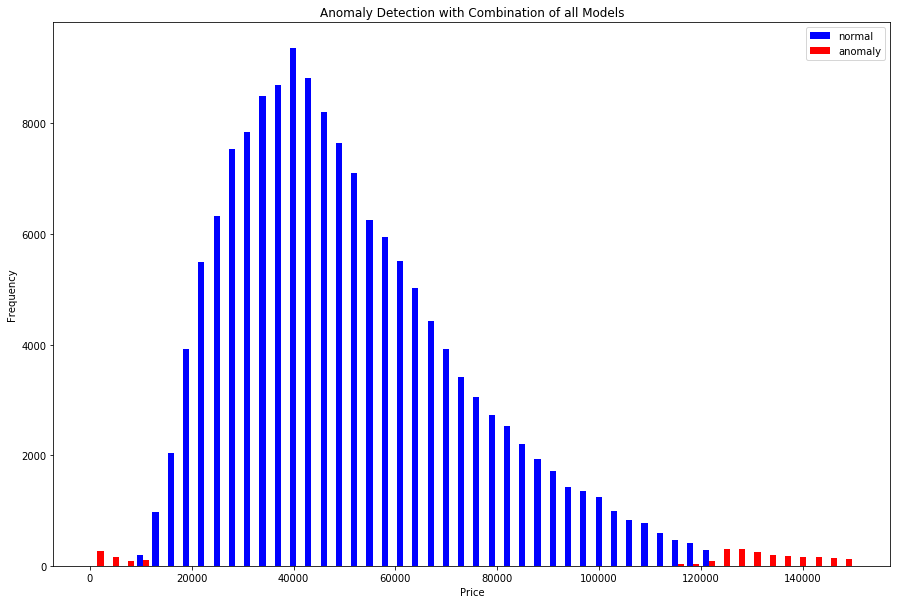

In [38]:
normal = df.loc[df['AnomalyScore'] > -4, 'price']
anomaly = df.loc[df['AnomalyScore'] <= -4, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Anomaly Detection with Combination of all Models')
plt.legend()
plt.show()

## Remove the anomalies from the original dataset

In [39]:
df = df[df['AnomalyScore'] > -4]
df = df.drop(columns=['IQR', 
                      'IsolationForest', 
                      'OneClassSVM', 
                      'LocalOutlierFactor', 
                      'RobustCovariance', 
                      'KNN'])
df.head(10)

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,AnomalyScore
0,116.475489,40.019520,8/9/16,1464,106,415.0,31680,131.00,2,1,1,1,1,2005,3,6,0.217,1,0,1,7,56021,16,8,0
1,116.453917,39.881534,7/28/16,903,126,575.0,43436,132.38,2,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,7,0
2,116.561978,39.877145,12/11/16,1271,48,1030.0,52021,198.00,3,2,1,3,4,2005,3,6,0.500,1,0,0,7,48160,16,12,0
3,116.438010,40.076114,9/30/16,965,138,297.5,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238,16,9,-1
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588,16,8,-2
5,116.466280,39.991363,7/22/16,861,57,275.6,52000,53.00,1,0,1,1,4,2005,3,6,0.333,1,1,0,7,67738,16,7,0
6,116.482586,39.891991,7/14/16,851,167,275.0,37672,73.00,2,1,1,1,4,1997,4,2,0.500,0,0,0,7,50112,16,7,0
7,116.453917,39.881534,9/7/16,904,138,800.0,49521,161.55,3,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,9,0
8,116.555729,40.162058,9/4/16,873,218,134.0,27917,48.00,1,0,1,1,3,2009,1,2,0.333,0,0,0,13,44235,16,9,-2
9,116.453086,39.898397,9/5/16,865,134,380.0,55883,68.00,1,0,0,0,1,2009,4,6,0.308,1,1,1,1,78590,16,9,0


In [40]:
df = df.reset_index()
df = df.drop(columns=['index'])
df.head(10)

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,Years,Months,AnomalyScore
0,116.475489,40.019520,8/9/16,1464,106,415.0,31680,131.00,2,1,1,1,1,2005,3,6,0.217,1,0,1,7,56021,16,8,0
1,116.453917,39.881534,7/28/16,903,126,575.0,43436,132.38,2,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,7,0
2,116.561978,39.877145,12/11/16,1271,48,1030.0,52021,198.00,3,2,1,3,4,2005,3,6,0.500,1,0,0,7,48160,16,12,0
3,116.438010,40.076114,9/30/16,965,138,297.5,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238,16,9,-1
4,116.428392,39.886229,8/28/16,927,286,392.0,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588,16,8,-2
5,116.466280,39.991363,7/22/16,861,57,275.6,52000,53.00,1,0,1,1,4,2005,3,6,0.333,1,1,0,7,67738,16,7,0
6,116.482586,39.891991,7/14/16,851,167,275.0,37672,73.00,2,1,1,1,4,1997,4,2,0.500,0,0,0,7,50112,16,7,0
7,116.453917,39.881534,9/7/16,904,138,800.0,49521,161.55,3,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539,16,9,0
8,116.555729,40.162058,9/4/16,873,218,134.0,27917,48.00,1,0,1,1,3,2009,1,2,0.333,0,0,0,13,44235,16,9,-2
9,116.453086,39.898397,9/5/16,865,134,380.0,55883,68.00,1,0,0,0,1,2009,4,6,0.308,1,1,1,1,78590,16,9,0


## Save to file

In [41]:
df.to_csv('Beijing_housing_price.csv')